# Imports

In [12]:
# Python standard library
from collections import defaultdict
import glob
import os

# Third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import screed

# Local python files
from path_constants import FIGURE_FOLDER, DATA_FOLDER, ORPHEUM_BENCHMARKING_FOLDER
from nb_utils import describe
from plot_constants import (
    PROTEIN_COLOR,
    DAYHOFF_COLOR,
    PEPTIDE_MOLTYPE_PALETTE,
    PEPTIDE_MOLTYPE_ORDER,
    PEPTIDE_ALPHABET_KSIZES,
    PEPTIDE_ALPHABET_PALETTES,
)
from mya_utils import (
    clean_common_names_of_species,
    BUSCO_MAMMALIA_SPECIES,
    MYA_COLOR_KWARGS,
    MYA_ORDER,
)

## Get number of protein sequences per species

In [13]:
proteome_folder = MAMMALIA_BUSCO_SUBSET_FOLDER

busco_mammalia_species = BUSCO_MAMMALIA_SPECIES.copy()

col = "proteome_size"
busco_mammalia_species[col] = 0
for fasta in glob.glob(os.path.join(proteome_folder, "*.fasta")):
    species_lower = os.path.basename(fasta).split("__")[-1].split(".")[0]
    proteome_size = sum(1 for _ in screed.open(fasta))

    busco_mammalia_species.loc[species_lower, col] = proteome_size
busco_mammalia_species = busco_mammalia_species.sort_values("mya")
describe(busco_mammalia_species)

(18, 4)
--- First 5 entries ---


,common_name,scientific_name,mya,proteome_size
scientific_lower,,,,
homo_sapiens,human,Homo sapiens,0.0,15066
macaca_mulatta,macaque,Macaca mulatta,29.4,5008
aotus_nancymaae,night monkey,Aotus nancymaae,43.2,7261
tupaia_chinensis,tupaia,Tupaia chinensis,82.0,1338
mus_musculus,house mouse,Mus musculus,90.0,14519


## Reindex BUSCO mammalia series to use common name

In [14]:
busco_mammalia_common = busco_mammalia_species.reset_index().set_index("common_name")

## Read ROC AUC csv

In [15]:
csv = os.path.join(
    ORPHEUM_BENCHMARKING_FOLDER,
    "busco_mammalia_coding_scores_roc_auc_score.csv",
)


combined_roc_auc_score = pd.read_csv(csv)
# combined_roc_auc_score = combined_roc_auc_score.join(distance_from_human_mya, on='species')

combined_roc_auc_score.species = combined_roc_auc_score.species.map(
    clean_common_names_of_species
)
# Everything decreases after k > 21
combined_roc_auc_score = combined_roc_auc_score.query("ksize <= 21")
combined_roc_auc_score = combined_roc_auc_score.join(
    busco_mammalia_common, on="species"
)
combined_roc_auc_score.head()

,species,alphabet,ksize,score_value,score_name,scientific_lower,scientific_name,mya,proteome_size
0,baiji,dayhoff,5,0.397805,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
1,baiji,dayhoff,6,0.363173,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
2,baiji,dayhoff,7,0.363950,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
3,baiji,dayhoff,8,0.385517,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
4,baiji,dayhoff,9,0.418185,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8


In [16]:
max_roc_scores = combined_roc_auc_score.groupby(
    ['species', 'alphabet']).score_value.max()
max_roc_scores.name = 'max_roc_auc'
max_roc_scores = max_roc_scores.reset_index()
max_roc_scores = max_roc_scores.join(busco_mammalia_common, on='species')
describe(max_roc_scores)

(36, 7)
--- First 5 entries ---


,species,alphabet,max_roc_auc,scientific_lower,scientific_name,mya,proteome_size
0,baiji,dayhoff,0.500255,lipotes_vexillifer,Lipotes vexillifer,96.0,8
1,baiji,protein,0.500607,lipotes_vexillifer,Lipotes vexillifer,96.0,8
2,bat,dayhoff,0.552860,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
3,bat,protein,0.503737,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
4,camel,dayhoff,0.500110,camelus_bactrianus,Camelus bactrianus,96.0,4


In [17]:
max_roc_scores.query('max_roc_auc > 0.6')

,species,alphabet,max_roc_auc,scientific_lower,scientific_name,mya,proteome_size
14,hedgehog,dayhoff,0.869341,erinaceus_europaeus,Erinaceus europaeus,96.0,13448
15,hedgehog,protein,0.929230,erinaceus_europaeus,Erinaceus europaeus,96.0,13448
16,house mouse,dayhoff,0.880976,mus_musculus,Mus musculus,90.0,14519
17,house mouse,protein,0.938552,mus_musculus,Mus musculus,90.0,14519
18,human,dayhoff,0.996881,homo_sapiens,Homo sapiens,0.0,15066
19,human,protein,0.998456,homo_sapiens,Homo sapiens,0.0,15066
22,macaque,dayhoff,0.770334,macaca_mulatta,Macaca mulatta,29.4,5008
23,macaque,protein,0.789053,macaca_mulatta,Macaca mulatta,29.4,5008
24,night monkey,dayhoff,0.818646,aotus_nancymaae,Aotus nancymaae,43.2,7261
25,night monkey,protein,0.844914,aotus_nancymaae,Aotus nancymaae,43.2,7261


# Fig 2C,D

## Plot ROC AUC showing argmax for each divergence time -- both protein and dayhoff

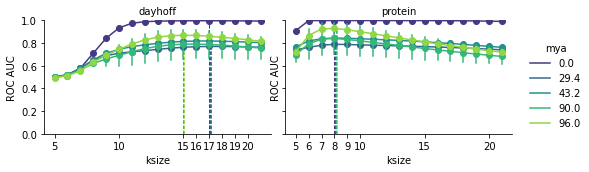

In [18]:
n_lines_plotted = defaultdict(int)
def plot_argmax(x, y, *args, **kwargs):
    idxmax = y.idxmax()
    
    global n_lines_plotted
    
    true_x = x[idxmax]
    adjusted_x = true_x + n_lines_plotted[true_x]/20
    
    plt.vlines(
        adjusted_x, 
        0, 
        y.max(),        
        linestyle='--',
        linewidth=1,
        *args, 
        **kwargs
    )
    n_lines_plotted[true_x] += 1

def pointplot_like(x, y, *args, **kwargs):
    """Like a pointplot, but x is true values not categorical"""
    new_y = y.groupby(x).mean()
    new_x = x.unique()
    plt.plot(new_x, new_y, 'o-', *args, **kwargs)
    
    y_stds = y.groupby(x).std()
    
    for x_pos, y_mean, y_sd in zip(new_x, new_y, y_stds):

        plt.plot([x_pos, x_pos], [y_mean - y_sd, y_mean + y_sd], *args, **kwargs)



data  = combined_roc_auc_score.query('proteome_size > 2500')


g = sns.FacetGrid(
    data=data, 
    height=2.5, aspect=1.5,
    col='alphabet',
    sharex=False,
    hue='mya',
    palette='viridis',
    hue_order=sorted(data['mya'].unique())
)
# g.map(sns.scatterplot, 'ksize', 'score_value')
g.map(pointplot_like, 'ksize', 'score_value')
g.add_legend()
g.map(plot_argmax, 'ksize', 'score_value')
g.set(ylabel='ROC AUC', 
      ylim=(0, 1), 
#       xticks=[5, 6, 7, 8, 9, 10, 15, 20]
     )
for ax in g.axes.flat:
    if 'protein' in ax.get_title():
        ax.set(xticks=[5, 6, 7, 8, 9, 10, 15, 20])
    else:
        ax.set(xticks=[5, 10, 15, 16, 17, 18, 19, 20])

g.set_titles('{col_name}')
pdf = os.path.join(
    FIGURE_FOLDER, 
    'leaftea_translate__human_mouse__roc_auc__protein_dayhoff.pdf')
g.savefig(pdf)

In [19]:
combined_roc_auc_score_dayhoff17_protein8 = combined_roc_auc_score.query('(alphabet == "dayhoff" and ksize == 17) or (alphabet == "protein" and ksize == 8)')
describe(combined_roc_auc_score_dayhoff17_protein8)

(36, 9)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name,scientific_lower,scientific_name,mya,proteome_size
12,baiji,dayhoff,17,0.499700,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
30,baiji,protein,8,0.500530,roc_auc,lipotes_vexillifer,Lipotes vexillifer,96.0,8
66,bat,dayhoff,17,0.499999,roc_auc,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
84,bat,protein,8,0.500009,roc_auc,rhinolophus_sinicus,Rhinolophus sinicus,96.0,1
120,camel,dayhoff,17,0.500095,roc_auc,camelus_bactrianus,Camelus bactrianus,96.0,4


In [20]:
combined_roc_auc_score_dayhoff17_protein8.query('proteome_size > 2000').groupby(['alphabet', 'mya']).score_value.mean()

alphabet  mya 
dayhoff   0.0     0.996881
          29.4    0.770334
          43.2    0.818646
          90.0    0.787676
          96.0    0.860161
protein   0.0     0.998456
          29.4    0.789053
          43.2    0.844914
          90.0    0.840868
          96.0    0.929230
Name: score_value, dtype: float64